In [7]:

import pandas as pd
import re #regex library to format fast to read into pd 
import os

import matplotlib.pyplot as plt
import feather

import numpy as np
import platform
import mne


from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,


                       permutation_t_test, permutation_cluster_1samp_test,spatio_temporal_cluster_1samp_test)
import sys
if platform.system()=='Darwin':
    os.chdir('/Volumes/BBC/BBC/WP1/data/EEG/tsk/')
    #sys.path.append('/Users/leupinv/BBC/WP1/data/Code/python/BBC')
    #if this doesn't work pound line right above this, restart the kernel, rerun the cell. 
    #Then uncomment the same line and rerun

else:
    #os.chdir('Z:/BBC/WP1/data/EEG/tsk')
    #sys.path.append('C:/Users/Vivi/switchdrive/BBC/WP1/data/Code/python/BBC')
    os.chdir('Z:/BBC/WP1/data/EEG/tsk')

from base.files_in_out import getListOfFiles,GetFiles
from stats.stats_helper import filter_list, tTest_ana
import stats.t_tests_cluster as clus
import stats.stats_helper as s_hp
import base.base_constants as cs
from stats.stats_helper import filter_list, tTest_ana, filter_list_equal

# load BF txt and plot it

In [2]:
from  stats.t_tests_cluster import plot_from_BF


In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False
plt.style.use('default')

mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False

In [4]:
def data_cutter(data, time_limits=[-0.3, 0.8], new_time_limits=[0.2, 0.6], sfreq=256):
    """
    Cuts a 3D EEG data array ( time x electrodes) based on specified time limits.
    Parameters:
        data (np.ndarray): EEG data of shape (electrodes, time)
        time_limits (list of float): Original epoch time range in seconds (e.g., [-0.3, 0.8])
        new_time_limits (list of float): Desired time range to extract (e.g., [0.2, 0.6])
        sfreq (int): Sampling frequency in Hz (default is 256)
    Returns:
        np.ndarray: The cut data with shape (new_time_points,electrodes)
    """
    # Calculate the sample indices corresponding to the new time limits
    start_idx = int(np.round((new_time_limits[0] - time_limits[0]) * sfreq))
    end_idx = int(np.round((new_time_limits[1] - time_limits[0]) * sfreq))
    # Cut the data along the time dimension (axis=1)
    return data[start_idx:end_idx,:]



In [5]:
idx=1
modlist=['modfit','awafit','rawerps','modfit_card']
cond_list=["awareness_unaware","awareness","awareness","card_phase_sys"]
#define variables
modtype=modlist[idx]
erp_type="hep"
cond=cond_list[idx]
dc_type="dc"

#load corresponding file 


file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [6]:
data=np.loadtxt(file_dir)
data.shape

(128, 256)

(128, 257)

In [78]:
%matplotlib qt
time_points=[0.505]
time_points_s=[round(x*1000) for x in time_points]
fig_evo,fig_topo=clus.plot_from_BF(data,log_trans=True,averages=0.015,start=-0.2,plot_times=time_points)

number of time pointst: 5
length of minimum time points to be significant: 1
at the moment if only one TF is significant the electrode will be displayed as sig


In [66]:
file_evo_dir=f'ana/deconvolution/figures/mass_evo_{modtype}_{erp_type}_{cond}_{dc_type}.svg'
fig_evo.savefig(file_evo_dir,format='svg')

In [67]:
file_topo_dir=f'ana/deconvolution/figures/topo_evo_{time_points_s}_{modtype}_{erp_type}_{cond}_{dc_type}.svg'
fig_topo.savefig(file_topo_dir,format='svg')

# Plot tvalues and use BF as mask

## aware vs unaware in aware fit

In [8]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/modfit/dc/{g_num}_modfit_hep_awareness_unaware_dc.ep'
f = open(file_dir)


In [9]:
data=np.loadtxt(file_dir)
data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])

data.shape

(204, 128)

In [10]:
erp_type='hep'
modtype='awafit'
subject_list=cs.G_N
X_awa=np.empty((len(subject_list),data.shape[1],data.shape[0]))
dc='nodc'
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/awafit/{dc}/{g_num}_aware_hep__Intercept__{dc}.ep'
    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


    X_awa[idx,:,:]=data.T




In [11]:
subject_list=cs.G_N
X_unawa=np.empty((len(subject_list),data.shape[1],data.shape[0]))
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/awafit/{dc}/{g_num}_unaware_hep__Intercept__{dc}.ep'

    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])

    X_unawa[idx,:,:]=data.T




### load bf

In [12]:
cond="awareness"
dc_type=dc

#load corresponding file



file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [13]:
data_BF=np.loadtxt(file_dir)
data_BF=data_BF
data_BF=data_cutter(data_BF.T,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7]).T
data_BF.shape

(128, 204)

In [14]:
X=X_awa-X_unawa

In [15]:
%matplotlib qt
filepath=f'{modtype}_{erp_type}_{cond}_{dc_type}'
s_hp.get_tTest(X,crop_value=[-0.1,0.7],FDR=False,mask_BF=data_BF,BF=True, plot_times=[0.505],averages=0.015,png=filepath)

-0.1
number of time pointst: 8
length of minimum time points to be significant: 1
at the moment if only one TF is significant the electrode will be displayed as sig
(128, 204)


(array([[ 0.18383931, -0.26656446, -0.40196204, ..., -0.14422776,
         -0.21477315, -0.23727737],
        [ 0.30345723, -0.09262065, -0.27866315, ...,  0.16750516,
          0.1218846 ,  0.05244283],
        [ 0.22487657,  0.0197908 , -0.01022627, ...,  0.82614221,
          0.81815018,  0.76042666],
        ...,
        [-0.38757145, -0.19659087, -0.11801472, ...,  1.1765845 ,
          1.43694864,  1.62983701],
        [ 0.16203319,  0.30083873,  0.32402557, ...,  0.4352594 ,
          0.6158562 ,  0.75359865],
        [-0.27310474, -0.10419017, -0.11735747, ...,  0.09273872,
          0.24389948,  0.37108317]]),
 array([[0.85541895, 0.79169083, 0.69065921, ..., 0.88631826, 0.83144737,
         0.81410989],
        [0.7637079 , 0.92684183, 0.78248083, ..., 0.86813522, 0.9038311 ,
         0.95853544],
        [0.82365235, 0.9843458 , 0.99191079, ..., 0.41546879, 0.41994345,
         0.45313819],
        ...,
        [0.7011633 , 0.84551896, 0.90686963, ..., 0.24892917, 0.16143481

# Card fit

In [213]:
erp_type='hep'
modtype='cardfit'
subject_list=cs.G_N
X_sys=np.empty((len(subject_list),data.shape[1],data.shape[0]))
dc='nodc'
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/cardfit/{dc}/{g_num}_sys_hep__Intercept__{dc}.ep'
    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])



    X_sys[idx,:,:]=data.T




In [214]:
subject_list=cs.G_N
X_dia=np.empty((len(subject_list),data.shape[1],data.shape[0]))
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/cardfit/{dc}/{g_num}_dia_hep__Intercept__{dc}.ep'
    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])

    X_dia[idx,:,:]=data.T




### load bf

In [215]:
cond="sys"
dc_type=dc

#load corresponding file



file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [19]:
data_BF=np.loadtxt(file_dir)
data_BF=data_cutter(data_BF.T,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7]).T
data_BF.shape

(128, 205)

In [20]:
X=X_sys-X_dia

NameError: name 'X_sys' is not defined

In [21]:
%matplotlib qt
filepath=f'{modtype}_{erp_type}_{cond}_{dc_type}'
s_hp.get_tTest(X,crop_value=[-0.1,0.7],FDR=False,mask_BF=data_BF,BF=True, plot_times=[0.55],averages=0.05,png=filepath,topo_limits=[-9,9])

NameError: name 'X' is not defined

## card phase (or single modfit)

In [2]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/modfit/dc/{g_num}_modfit_hep_awareness_unaware_dc.ep'
f = open(file_dir)


In [22]:
data=np.loadtxt(file_dir)
data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.6])

data.shape

(103, 257)

In [23]:
erp_type='hep'
modtype='modfit_card'
cond='card_phase_sys'
subject_list=cs.G_N
X=np.empty((len(subject_list),data.shape[1],data.shape[0]))
dc='dc'
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc}/{g_num}_{modtype}_hep_{cond}_{dc}.ep'
    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.6])


    X[idx,:,:]=data.T




ValueError: could not broadcast input array from shape (128,179) into shape (257,103)

### load bf

In [5]:

dc_type=dc

#load corresponding file



file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [6]:
data_BF=np.loadtxt(file_dir)
data_BF=data_cutter(data_BF.T,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.6]).T


In [7]:
%matplotlib qt
filepath=f'{modtype}_{erp_type}_{cond}_{dc_type}'
s_hp.get_tTest(X,crop_value=[-0.1,0.6],FDR=False,mask_BF=data_BF,BF=True, plot_times='peaks',averages=0.015,png=filepath)

-0.2


(array([[ 0.59177917,  0.22651826, -0.0566656 , ..., -0.99932455,
         -1.18403266, -1.38709549],
        [-0.02986289, -0.21541184, -0.41436102, ...,  1.11590517,
          1.02129637,  0.83984788],
        [-1.04133681, -1.09947292, -1.19625127, ...,  2.06851577,
          2.05000064,  1.96951758],
        ...,
        [-2.05163829, -2.08581226, -1.9960999 , ...,  0.80900226,
          1.2174415 ,  1.7738138 ],
        [-0.96067137, -0.93931299, -0.81089456, ...,  0.81952876,
          0.97853332,  1.33391654],
        [-0.7728368 , -0.60363692, -0.39463917, ...,  0.21698786,
          0.51645794,  0.88711299]]),
 array([[0.55858407, 0.82238746, 0.9552002 , ..., 0.32590342, 0.24601452,
         0.17598209],
        [0.97638098, 0.83095408, 0.68165876, ..., 0.27362427, 0.31555878,
         0.40786444],
        [0.30632334, 0.28060571, 0.24128775, ..., 0.04761112, 0.04950211,
         0.05851267],
        ...,
        [0.04933222, 0.0459026 , 0.05538937, ..., 0.4251017 , 0.23325043

## same for erp

In [6]:

#define variables
modtype='rawerps'
erp_type="hep"

dc_type="nodc"


filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename=f"maskOFF_correct_cfa_hep_norm_RRCA_list-ave.fif"
fp=filepath+filename
evo_awa=mne.read_evokeds(fp)

filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename=f"maskOFF_correct_cfa_hep_norm_RRCU_list-ave.fif"
fp=filepath+filename
evo_unawa=mne.read_evokeds(fp)


Reading ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/maskOFF_correct_cfa_hep_norm_RRCA_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.13 × hep/normal/correct/aware/R/exh/RRCA + 0.08 × hep/normal/correct/aware/R/inh/RRCA + 0.47 × hep/normal/correct/aware/R2/exh/RRCA + 0.32 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g01)
        0 CTF compensation matrices available
        nave = 345 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.18 × hep/normal/correct/aware/R/exh/RRCA + 0.15 × hep/normal/correct/aware/R/inh/RRCA + 0.42 × hep/normal/correct/aware/R2/exh/RRCA + 0.25 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g03)
    

In [8]:
evo_awa[0].nave

345

In [11]:
list_nave_awa=[]
for evo in evo_awa:
    list_nave_awa.append(evo.nave)




In [12]:
np.average(list_nave_awa)

321.6

In [13]:
list_nave_unawa=[]
for evo in evo_unawa:
    list_nave_unawa.append(evo.nave)




In [14]:
np.average(list_nave_unawa)

317.3333333333333

In [15]:
rej_data=[9,17,12,6,7,57,6,16,2,24,4,4,1,9,11,6,19,14,8,11,9,7,13,6,3,14,6,29,6,22]

In [18]:
np.average(rej_data)


11.933333333333334

### load bf

In [29]:
cond="awareness"

#load corresponding file


file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [46]:
data_BF=np.loadtxt(file_dir)
data_BF=data_cutter(data_BF.T,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.705]).T
data_BF.shape

(128, 206)

In [47]:
filepath=f'{modtype}_{erp_type}_{cond}_{dc_type}'
s_hp.tTest_ana([evo_awa,evo_unawa],crop_value=[-0.1,0.7],BF=True,mask_BF=data_BF,plot_times=[0.505],averages=0.015,png=filepath)

C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:134: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  data_crop = evoked[0].copy().crop(crop_value[0], crop_value[1])
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: Run

(30, 128, 206)
(30, 128, 206)
-0.1
number of time pointst: 7
length of minimum time points to be significant: 1
at the moment if only one TF is significant the electrode will be displayed as sig
(128, 206)


(array([[ 0.10700119, -0.46874747, -0.92904716, ...,  0.36161178,
          0.07004547, -0.28370991],
        [ 0.498571  ,  0.0868461 , -0.30259404, ...,  1.10572119,
          0.87494917,  0.4354376 ],
        [ 0.624904  ,  0.26361414, -0.00418928, ...,  1.92052894,
          1.80195764,  1.42741273],
        ...,
        [-0.98358122, -0.55490453, -0.15475385, ...,  1.54821286,
          1.68528298,  1.788805  ],
        [ 0.43370777,  1.102807  ,  1.58351357, ...,  0.23273036,
          0.45368427,  0.73997493],
        [ 0.08034865,  0.72091198,  1.19354127, ..., -1.30829038,
         -0.81301381, -0.38353595]]),
 array([[0.91552485, 0.6427548 , 0.36053373, ..., 0.72026364, 0.94463826,
         0.77864841],
        [0.62184228, 0.93139073, 0.76435909, ..., 0.27793619, 0.38879065,
         0.66646866],
        [0.53692042, 0.79394143, 0.99668613, ..., 0.06467317, 0.08195691,
         0.16414106],
        ...,
        [0.33345681, 0.58321505, 0.87808743, ..., 0.13241611, 0.10266699

# Compute gavgs

In [4]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/modfit/dc/{g_num}_modfit_hep_awareness_unaware_dc.ep'
f = open(file_dir)


In [5]:
data=np.loadtxt(file_dir)
data.shape

(256, 128)

In [18]:
subject_list=cs.G_N
X=np.empty((len(subject_list),data.shape[1],data.shape[0]))
cond_list=["awareness_unaware","awareness","awareness","card_phase_sys","_Intercept_","awareness_unaware_card_phase_sys"]
fit='base'
dc='dc'
beta_type=cond_list[4]

for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/{fit}/{dc}/{g_num}_{fit}_hep_{beta_type}_{dc}.ep'
    data=np.loadtxt(file_dir)

    X[idx,:,:]=data.T




In [19]:
gavg=np.mean(X,0).T
filename=f'ana/deconvolution/ep_betas/{fit}/{dc}/gavg_{fit}_hep_{beta_type}_{dc}.ep'

np.savetxt(filename,gavg)

# For cardfit/awafit

In [4]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/cardfit/dc/{g_num}_sys_hep__Intercept__dc.ep'
f = open(file_dir)


In [5]:
data=np.loadtxt(file_dir)

data.shape

(256, 128)

In [12]:
subject_list=cs.G_N
X=np.empty((len(subject_list),data.shape[1],data.shape[0]))
sys_cond='unaware'
fit='awafit'
dc='nodc'
beta_type="_Intercept_"

for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/{fit}/{dc}/{g_num}_{sys_cond}_hep_{beta_type}_{dc}.ep'
    data=np.loadtxt(file_dir)

    X[idx,:,:]=data.T




In [13]:
gavg=np.mean(X,0).T
filename=f'ana/deconvolution/ep_betas/{fit}/{dc}/gavg_{fit}_hep_{sys_cond}_{dc}.ep'

np.savetxt(filename,gavg)

# Plot waveforms gavgs
## plot erps

In [48]:

#define variables
modtype='rawerp'
erp_type="hep"
cond='unaware'
dc_type="nodc"


filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename=f"maskOFF_correct_cfa_hep_norm_RRCA_list-ave.fif"
fp=filepath+filename
evo_awa=mne.read_evokeds(fp)

filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename=f"maskOFF_correct_cfa_hep_norm_RRCU_list-ave.fif"
fp=filepath+filename
evo_unawa=mne.read_evokeds(fp)


Reading ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/maskOFF_correct_cfa_hep_norm_RRCA_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.13 × hep/normal/correct/aware/R/exh/RRCA + 0.08 × hep/normal/correct/aware/R/inh/RRCA + 0.47 × hep/normal/correct/aware/R2/exh/RRCA + 0.32 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g01)
        0 CTF compensation matrices available
        nave = 345 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.18 × hep/normal/correct/aware/R/exh/RRCA + 0.15 × hep/normal/correct/aware/R/inh/RRCA + 0.42 × hep/normal/correct/aware/R2/exh/RRCA + 0.25 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g03)
    

In [49]:
evo_awa=[ev.crop(-0.1,0.7) for ev in evo_awa]
evo_unawa=[ev.crop(-0.1,0.7) for ev in evo_unawa]

In [50]:
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

if phy_sig=='rsp_phase':
    colors=[['olivedrab','darkgreen'],['tab:pink','purple']]
elif phy_sig=='cardiac_phase':
    colors=[['c','b'],['tab:orange','r']]
else:
    colors=['k','grey']

In [54]:


evokeds=dict(aware=evo_awa,unaware=evo_unawa)

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,colors=['r','g'],ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-1.5,1.5]))
    n+=1


['A5', 'A14', 'A16', 'A18', 'A23']
combining channels using "mean"
combining channels using "mean"
['C32', 'D4']
combining channels using "mean"
combining channels using "mean"
['B12', 'B14', 'B23', 'B24']
combining channels using "mean"
combining channels using "mean"


In [55]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_{dc_type}.svg'
fig.savefig(file_dir,format='svg')

## plot awafit awa vs unawa

In [65]:

#define variables
modtype='awafit'
erp_type="hep"
cond='aware'
dc_type="nodc"

#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [66]:
data_aware=np.loadtxt(file_dir)
data_aware=data_cutter(data_aware,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(179, 128)

In [67]:

#define variables
modtype='awafit'

cond='unaware'


#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [68]:
data_unaware=np.loadtxt(file_dir)
data_unaware=data_cutter(data_unaware,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [69]:
def get_evo(data,tmin=-0.1):
    biosemi_montage = mne.channels.make_standard_montage('biosemi128')

    info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=256.,
                           ch_types='eeg')
    evok=mne.EvokedArray(data,info,tmin=tmin)
    evok.set_montage(biosemi_montage)
    return evok

In [70]:
evo_awa=get_evo(data_aware.T)
evo_unawa=get_evo(data_unaware.T)

In [71]:
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

regions=dict(nodc_post=['A13','A14','A16','A15','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

if phy_sig=='rsp_phase':
    colors=[['olivedrab','darkgreen'],['tab:pink','purple']]
elif phy_sig=='cardiac_phase':
    colors=[['c','b'],['tab:orange','r']]
else:
    colors=['k','grey']

In [72]:


evokeds=dict(aware=evo_awa,unaware=evo_unawa)

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, colors=['r','g'],picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-1.5*1e6,1.5*1e6]),truncate_xaxis=False)
    n+=1


['A5', 'A14', 'A16', 'A18', 'A23']
combining channels using "mean"
combining channels using "mean"
['C32', 'D4']
combining channels using "mean"
combining channels using "mean"
['B12', 'B14', 'B23', 'B24']
combining channels using "mean"
combining channels using "mean"


In [73]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_{dc_type}.svg'
fig.savefig(file_dir,format='svg')

## plot cardfit sys vs dia

In [223]:

#define variables
modtype='cardfit'
erp_type="hep"
cond_1='sys'
dc_type_1="nodc"

k_1=f'{cond_1}_{dc_type_1}'
#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type_1}/gavg_{modtype}_{erp_type}_{cond_1}_{dc_type_1}.ep'
f = open(file_dir)

In [224]:
data_1=np.loadtxt(file_dir)
data_1=data_cutter(data_1,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(204, 128)

In [225]:

#define variables

dc_type_2="nodc"
cond_2='dia'
k_2=f'{cond_2}_{dc_type_2}'

#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type_2}/gavg_{modtype}_{erp_type}_{cond_2}_{dc_type_2}.ep'
f = open(file_dir)

In [226]:
data_2=np.loadtxt(file_dir)
data_2=data_cutter(data_2,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [227]:
def get_evo(data,tmin=-0.1):
    biosemi_montage = mne.channels.make_standard_montage('biosemi128')

    info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=256.,
                           ch_types='eeg')
    evok=mne.EvokedArray(data,info,tmin=tmin)
    evok.set_montage(biosemi_montage)
    return evok

In [228]:
evo_1=get_evo(data_1.T)
evo_2=get_evo(data_2.T)

In [229]:
%matplotlib qt
if 'sys' in cond_1:
    color=['tab:orange','tab:orange']
else:
    color=['#1f77b4','#1f77b4']
evokeds={k_1:evo_1,k_2:evo_2}



In [ ]:

fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, colors=color,picks=['A23'],show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',ylim=dict(eeg=[-3*1e6,3*1e6]),vlines=[0,0.7],linestyles=['-','--','-','--'])

In [232]:
%matplotlib qt

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.7],ylim=dict(eeg=[-3*1e6,3*1e6]), linestyles=['--'])
    n+=1


AttributeError: 'list' object has no attribute 'items'

In [86]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond_1}{cond_2}_{dc_type_1}_oz.svg'
fig_fin[0].savefig(file_dir,format='svg')

In [131]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond_1}_dcnodc_oz.svg'
fig_fin[0].savefig(file_dir,format='svg')

In [233]:
for cond,evo in evokeds.items():
    if 'sys'in cond:
        color=['tab:orange']
    else:
        color=['#1f77b4']
    sub_dict={cond:evo}
    fig_fin=mne.viz.plot_compare_evokeds(sub_dict,ci=False,colors=color, picks=['A23'],show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',ylim=dict(eeg=[-3*1e6,3*1e6]),vlines=[0,0.7],linestyles=['--'])
    file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_oz.svg'
    fig_fin[0].savefig(file_dir,format='svg')


combining channels using "mean"


C:\Users\Vivi\AppData\Local\Temp\ipykernel_1836\257251769.py:7: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_fin=mne.viz.plot_compare_evokeds(sub_dict,ci=False,colors=color, picks=['A23'],show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',ylim=dict(eeg=[-3*1e6,3*1e6]),vlines=[0,0.7],linestyles=['--'])


combining channels using "mean"


C:\Users\Vivi\AppData\Local\Temp\ipykernel_1836\257251769.py:7: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_fin=mne.viz.plot_compare_evokeds(sub_dict,ci=False,colors=color, picks=['A23'],show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',ylim=dict(eeg=[-3*1e6,3*1e6]),vlines=[0,0.7],linestyles=['--'])


In [61]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_dcnodc_oz.svg'
fig.savefig(file_dir,format='svg')

## Plot others

In [146]:

#define variables
modtype='base'
erp_type="hep"
cond='_Intercept_'
dc_type="dc"

#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [147]:
data_1=np.loadtxt(file_dir)
data_1=data_cutter(data_1,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(256, 128)

In [148]:

#define variables
#modtype='modfit_card'

dc_type="nodc"


#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}.ep'
f = open(file_dir)

In [149]:
data_2=np.loadtxt(file_dir)
data_2=data_cutter(data_2,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [151]:
def get_evo(data,tmin=-0.1):
    biosemi_montage = mne.channels.make_standard_montage('biosemi128')

    info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=256.,
                           ch_types='eeg')
    evok=mne.EvokedArray(data,info,tmin=tmin)
    evok.set_montage(biosemi_montage)
    return evok

In [152]:
evo_1=get_evo(data_1.T)
evo_2=get_evo(data_2.T)

In [107]:
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

In [153]:
regions=['A23']

regions=dict(nodc_post=['A13','A14','A16','A15','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

if phy_sig=='rsp_phase':
    colors=[['olivedrab','darkgreen'],['tab:pink','purple']]
elif phy_sig=='cardiac_phase':
    colors=[['c','b'],['tab:orange','r']]
else:
    colors=['k','grey']

AttributeError: 'list' object has no attribute 'items'

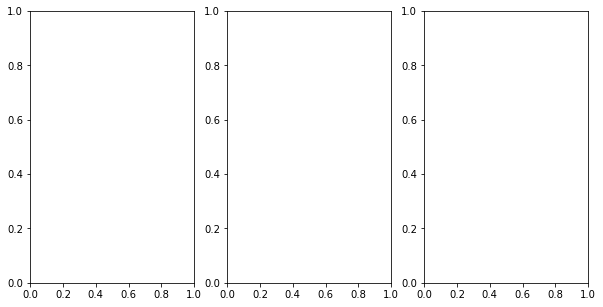

In [46]:


evokeds=dict(nodc=evo_1,dc=evo_2)

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.49,0.52],ylim=dict(eeg=[-1.5*1e6,1.5*1e6]))
    n+=1


In [154]:


evokeds=dict(dc=evo_1,nodc=evo_2)



fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks='A23',show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-3*1e6,3*1e6]),linestyles=['-','--','-','--'],colors=['k','k'])


combining channels using "mean"
combining channels using "mean"


C:\Users\Vivi\AppData\Local\Temp\ipykernel_1836\2005466826.py:5: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks='A23',show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-3*1e6,3*1e6]),linestyles=['-','--','-','--'],colors=['k','k'])


In [155]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_nodcdc.svg'
fig_fin[0].savefig(file_dir,format='svg')

# Load erps and export to ep to then perform BF on R

In [5]:
awa='unaware'
if awa=='aware':
    cond="RRCA"
elif awa=='unaware':
    cond="RRCU"
else:
    print('error in awa cond')


filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename=f"maskOFF_correct_cfa_hep_norm_{cond}_list-ave.fif"
fp=filepath+filename
evo=mne.read_evokeds(fp)

Reading ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/maskOFF_correct_cfa_hep_norm_R_unaware_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.51 × hep/normal/correct/unaware/R/exh/RRCU + 0.49 × hep/normal/correct/unaware/R/inh/RRCU
 G_n= g01)
        0 CTF compensation matrices available
        nave = 74 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.61 × hep/normal/correct/unaware/R/exh/RRCU + 0.39 × hep/normal/correct/unaware/R/inh/RRCU
 G_n= g03)
        0 CTF compensation matrices available
        nave = 62 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correctio

In [34]:
for ev in evo:
    g_num=ev.comment[-3:]
    ev.crop(None,0.8)
    data=ev.data.T
    filepath='ana/deconvolution/ep_betas/rawerps/nodc/'
    filename=f'{g_num}_{awa}_hep_rawerps_nodc.ep'
    fp=filepath+filename
    np.savetxt(fp,data)


In [15]:

ev.comment[-3:]

'g01'

# Test ERPs R1 vs R2


In [250]:
cond1='R'
cond2='R2'
filepath='ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/'
filename_1=f"maskOFF_correct_cfa_hep_norm_{cond1}_list-ave.fif"
fp_1=filepath+filename_1
evo_1=mne.read_evokeds(fp_1)
filename_2=f"maskOFF_correct_cfa_hep_norm_{cond2}_list-ave.fif"
fp_2=filepath+filename_2
evo_2=mne.read_evokeds(fp_2)

Reading ana/MNE/evo_list/maskOFF/correct/cfa/hep/norm/maskOFF_correct_cfa_hep_norm_R_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.31 × hep/normal/correct/aware/R/exh/RRCA + 0.19 × hep/normal/correct/aware/R/inh/RRCA + 0.26 × hep/normal/correct/unaware/R/exh/RRCU + 0.24 × hep/normal/correct/unaware/R/inh/RRCU
 G_n= g01)
        0 CTF compensation matrices available
        nave = 147 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.36 × hep/normal/correct/aware/R/exh/RRCA + 0.31 × hep/normal/correct/aware/R/inh/RRCA + 0.21 × hep/normal/correct/unaware/R/exh/RRCU + 0.13 × hep/normal/correct/unaware/R/inh/RRCU
 G_n= g03)
   

In [136]:
s_hp.tTest_ana([evo_1,evo_2],crop_value=(-0.2,0.8),p_val=.005)

C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:134: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199219 sec)
  data_crop = evoked[0].copy().crop(crop_value[0], crop_value[1])
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:151:

(30, 128, 257)
(30, 128, 257)
-0.2


(array([[ 0.38364904,  0.13064933, -0.13025776, ...,  4.68183834,
          4.56078523,  4.53161644],
        [-0.96970458, -1.26204709, -1.55719402, ...,  6.7411199 ,
          6.56867121,  6.38699104],
        [-2.41905023, -2.62215091, -2.84065058, ...,  7.16505974,
          6.9884192 ,  6.85274007],
        ...,
        [-2.02571562, -2.17316039, -2.07879787, ...,  1.19254948,
          1.53183285,  1.85181908],
        [-0.76686227, -0.82565364, -0.724548  , ..., -1.01394771,
         -0.76216541, -0.41024876],
        [-0.5046647 , -0.40400419, -0.12667367, ..., -2.5585053 ,
         -2.24770685, -2.03072342]]),
 array([[7.04036946e-01, 8.96954818e-01, 8.97261850e-01, ...,
         6.13746020e-05, 8.58252735e-05, 9.30373004e-05],
        [3.40212435e-01, 2.16987846e-01, 1.30271753e-01, ...,
         2.13294570e-07, 3.39012885e-07, 5.54081094e-07],
        [2.20635038e-02, 1.37763397e-02, 8.15033823e-03, ...,
         6.91903443e-08, 1.10339093e-07, 1.58280983e-07],
        ...,


In [263]:
evokeds=dict(R=evo_1)
picked=('A23')
fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean')


combining channels using "mean"


C:\Users\Vivi\AppData\Local\Temp\ipykernel_4024\3109885288.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean')


In [265]:
modtype='rawerps'
erp_type='hep'
cond='R'
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_nodc.svg'
fig_fin[0].savefig(file_dir,format='svg')

In [266]:
evokeds=dict(R2=evo_2)
fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean')

combining channels using "mean"


C:\Users\Vivi\AppData\Local\Temp\ipykernel_4024\548891214.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,combine='mean')


In [267]:
cond='R2'
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_nodc.svg'
fig_fin[0].savefig(file_dir,format='svg')

# Check avg HEP component anova

In [6]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/modfit/dc/{g_num}_modfit_hep_awareness_unaware_dc.ep'
f = open(file_dir)


In [7]:
data=np.loadtxt(file_dir)
data.shape

(256, 128)

In [12]:
subject_list=cs.G_N
X=np.empty((len(subject_list),data.shape[1],data.shape[0]))
cond_list=["awareness_unaware","awareness","awareness","card_phase_sys","_Intercept_","awareness_unaware_card_phase_sys"]

fit='awafit'
dc_list=['dc','nodc']
beta_type=cond_list[4]
aware_list=['aware','unaware']

main_dict={}

for awa_cond in aware_list:
    for dc_cond in dc_list:
        local_erp_list=[]
        for idx,g_num in enumerate(subject_list):
            file_dir=f'ana/deconvolution/ep_betas/{fit}/{dc_cond}/{g_num}_{awa_cond}_hep_{beta_type}_{dc_cond}.ep'
            data=np.loadtxt(file_dir).T
            evo=s_hp.get_evo(data,tmin=-0.2)
            local_erp_list.append(evo)
        key_dict= f'{awa_cond} {dc_cond}'
        main_dict[key_dict]=local_erp_list






In [30]:
crop_period=[0.49,0.52]
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

erp_df=s_hp.get_erp_df(main_dict,crop_period,regions['nodc'])

(30, 4, 9)
(30, 4, 9)
(30, 4, 9)
(30, 4, 9)


In [31]:
erp_df=pd.DataFrame.from_dict(erp_df)
erp_df['id']=erp_df.index
wide1=pd.wide_to_long(erp_df,stubnames=['aware','unaware'],i='id',j='Deconvolution',sep="",suffix='\D+')
wide1.rename(columns=dict(aware='AmplitudeAware',unaware='AmplitudeUnaware'),inplace=True)
wide1.reset_index(inplace=True)
wide2=pd.wide_to_long(wide1,stubnames=['Amplitude'],i=['Deconvolution','id'],j='Awareness',sep="",suffix='\D+')
wide2.reset_index(inplace=True)
wide2

,Deconvolution,id,Awareness,Amplitude
0,dc,0,Aware,-0.256916
1,dc,0,Unaware,-0.234456
2,dc,1,Aware,-0.674464
3,dc,1,Unaware,0.689751
4,dc,2,Aware,-0.198474
...,...,...,...,...
115,nodc,27,Unaware,-0.161467
116,nodc,28,Aware,-0.458357
117,nodc,28,Unaware,-0.080275
118,nodc,29,Aware,-0.742644


In [32]:
import pingouin as pg
pg.rm_anova(data=wide2,dv='Amplitude',within=['Awareness','Deconvolution'],subject='id',effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Awareness,1.138820,1,29,1.138820,10.920489,0.002537,0.002537,0.273556,1.0
1,Deconvolution,0.002550,1,29,0.002550,0.020620,0.886811,0.886811,0.000711,1.0
2,Awareness * Deconvolution,0.020947,1,29,0.020947,1.527859,0.226353,0.226353,0.050048,1.0


In [33]:
pg.pairwise_tests(data=wide2,dv='Amplitude',within=['Deconvolution','Awareness'],subject='id',padjust='fdr_bh',effsize='cohen')

,Contrast,Deconvolution,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Deconvolution,-,dc,nodc,True,True,-0.143598,29.0,two-sided,0.886811,NaN,NaN,0.196,-0.022366
1,Awareness,-,Aware,Unaware,True,True,-3.304616,29.0,two-sided,0.002537,NaN,NaN,14.644,-0.479564
2,Deconvolution * Awareness,dc,Aware,Unaware,True,True,-2.329734,29.0,two-sided,0.026988,0.026988,fdr_bh,1.968,-0.403567
3,Deconvolution * Awareness,nodc,Aware,Unaware,True,True,-4.305676,29.0,two-sided,0.000173,0.000347,fdr_bh,157.954,-0.466814


In [39]:
%matplotlib qt
import seaborn as sns
sns.boxplot(data=wide2,x='Deconvolution',hue='Awareness',y='Amplitude')

<AxesSubplot:xlabel='Deconvolution', ylabel='Amplitude'>

In [40]:
sns.barplot(data=wide2,x='Deconvolution',hue='Awareness',y='Amplitude')

<AxesSubplot:xlabel='Deconvolution', ylabel='Amplitude'>

check hep for mask on

# VEPs

In [2]:
g_num=None
eeg_format='-ave.fif'
eeg_exp='tsk'
datafolder='ana/MNE/evo_list'


#files = getListOfFiles(datafolder,g_num)

files = GetFiles(datafolder,g_num=g_num,eeg_format=eeg_format)

evo_files=files.fflist

In [10]:
phy_cond=''
rsp_cond='n'
if rsp_cond=='o':
    rsp_cond_lab='tsk_o_'
elif rsp_cond=='n':
    rsp_cond_lab=''

cond1=mne.read_evokeds(f'ana/MNE/evo_list/maskON/correct/cfa/hep/norm/maskON_correct_cfa_hep_norm_R2_aware_list-ave.fif')
cond2=mne.read_evokeds(f'ana/MNE/evo_list/maskON/correct/cfa/hep/norm/maskON_correct_cfa_hep_norm_R2_unaware_list-ave.fif')

Reading ana/MNE/evo_list/maskON/correct/cfa/hep/norm/maskON_correct_cfa_hep_norm_R2_aware_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.64 × hep/normal/correct/aware/R2/exh/RRCA + 0.36 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g01)
        0 CTF compensation matrices available
        nave = 152 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.61 × hep/normal/correct/aware/R2/exh/RRCA + 0.39 × hep/normal/correct/aware/R2/inh/RRCA
 G_n= g03)
        0 CTF compensation matrices available
        nave = 183 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction app

In [11]:
evo_awa=[ev.crop(-0.1,0.7) for ev in cond1]
evo_unawa=[ev.crop(-0.1,0.7) for ev in cond2]

In [15]:
%matplotlib qt
data_shape=[-0.1,0.7]
time_plot=[0.15]

ts,ps=tTest_ana([evo_awa,evo_unawa],crop_value=data_shape,FDR=False,plot_times=[0.505],averages=0.02,p_val=0.01, topo_limits=[-6,6])

C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:141: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  data_crop = evoked[0].copy().crop(crop_value[0], crop_value[1])
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:158: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:158: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:158: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (0.699219 sec)
  X[idx, :, :] = ev.copy().crop(crop_value[0], crop_value[1]).data
C:\Users\Vivi\Documents\GitHub\unfold_proj\stats\stats_helper.py:158: Run

(30, 128, 206)
(30, 128, 206)
-0.1
number of time pointst: 11
length of minimum time points to be significant: 1
at the moment if only one TF is significant the electrode will be displayed as sig
(128, 206)
